In this script I try some of the possible ways of correlating the segmentation with the nodes communities

- By using the communities COM and the segmentation
- By using the correlation between the parcellation and the community of provenience


In [2]:
import nibabel as nib
import numpy as np
import networkx as nx
from skimage.measure import marching_cubes
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import networkx as nx
import os
import numpy as np
from glob import glob
import nibabel as nib
import nibabel.freesurfer.mghformat as mghf # read mgz images
from skimage.morphology import skeletonize_3d
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors




In [3]:
# Path to the main directory containing the folders with data
main_directory = "PR-graphomics/sequences/"

# List all subfolders inside the main directory
folders = [f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))]
folder = folders[60]

print(f"Accessing folder: {folder}")
folder_path = os.path.join(main_directory, folder)
    
#In this way I add to the address the folder inside the first one
folder_path = os.path.join(folder_path, os.listdir(folder_path)[0])
#aparc.DKTatlas+aseg.deep.mgz aparc.DKTatlas+aseg.deep.nii.gz
image_path = os.path.join(folder_path, 'aparc.DKTatlas+aseg.deep.mgz')
graph_path = os.path.join(folder_path, 'sk-graph.pickle')
weighted_graph_path =  os.path.join(folder_path, 'sk-weighted_graph.pickle')
vol = mghf.load(image_path)

volume = vol.get_fdata()
verts, faces, normals, values = marching_cubes(volume, 0)

ptx, pty, ptz = verts.T
skeleton = skeletonize_3d(volume != 0)
graph = nx.read_gpickle(weighted_graph_path)

print('Number of nodes in he graph: ', str(len(graph.nodes())))

Accessing folder: 4026


/tmp/ipykernel_62593/1963283222.py:23: FutureWarning: `skeletonize_3d` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.morphology.skeletonize` instead.
  skeleton = skeletonize_3d(volume != 0)


Number of nodes in he graph:  1266


In [4]:

def louvain_with_target_communities(graph, target_communities, initial_resolution=5, max_iter=100, tolerance=1):
    """
    Run Louvain community detection repeatedly, adjusting the resolution and handling oscillations 
    until the target number of communities is reached.

    Parameters:
    - graph: NetworkX graph on which to perform community detection.
    - target_communities: The desired number of communities.
    - initial_resolution: Starting value for the resolution parameter (default is 1.0).
    - max_iter: Maximum number of iterations to try to reach the target (default is 100).
    - tolerance: Initial tolerance for adjusting the resolution (default is 0.1).

    Returns:
    - A tuple of (partition, num_communities, final_resolution), where:
        - partition is a dictionary mapping each node to its community.
        - num_communities is the number of communities in the final partition.
        - final_resolution is the final value of the resolution parameter used.
    """
    resolution = initial_resolution
    last_num_communities = None
    oscillation_count = 0  # Counter to track oscillations

    for i in range(max_iter):
        # Perform Louvain community detection with the current resolution
        partition = nx.community.louvain_communities(graph, resolution=resolution)
        num_communities = len(list(partition))
        print(f"Cycle {i +1}, resolution = {resolution}, number of communities = {num_communities}")

        # Check if the target number of communities has been achieved
        if num_communities == target_communities:
            print(f"Target achieved in {i+1} iterations with resolution={resolution}.")
            return partition, num_communities, resolution

        # Check for oscillation by comparing with the previous number of communities
        if last_num_communities is not None and (
            (num_communities > target_communities and last_num_communities < target_communities) or
            (num_communities < target_communities and last_num_communities > target_communities)
        ):
            oscillation_count += 1
            if oscillation_count >= 2:
                # Halve the tolerance if we detect oscillation
                tolerance /= 2
                oscillation_count = 0  # Reset oscillation count
                print(f"Oscillation detected. Reducing tolerance to {tolerance}")

        # Update the resolution based on whether we need more or fewer communities
        if num_communities > target_communities:
            resolution -= tolerance  # Increase resolution to reduce the number of communities
        else:
            resolution += tolerance  # Decrease resolution to increase the number of communities

        # Update last number of communities for the next iteration
        last_num_communities = num_communities

    print("Warning: Target number of communities not achieved within max_iter.")
    return partition, num_communities, resolution

comm_number = len(np.unique(volume))
communities, number, res = louvain_with_target_communities(graph, comm_number, max_iter= 1000, tolerance = 1) 

#print(len(communities))

Cycle 1, resolution = 5, number of communities = 83
Cycle 2, resolution = 6, number of communities = 95
Cycle 3, resolution = 7, number of communities = 102
Cycle 4, resolution = 6, number of communities = 93
Oscillation detected. Reducing tolerance to 0.5
Cycle 5, resolution = 6.5, number of communities = 96
Target achieved in 5 iterations with resolution=6.5.


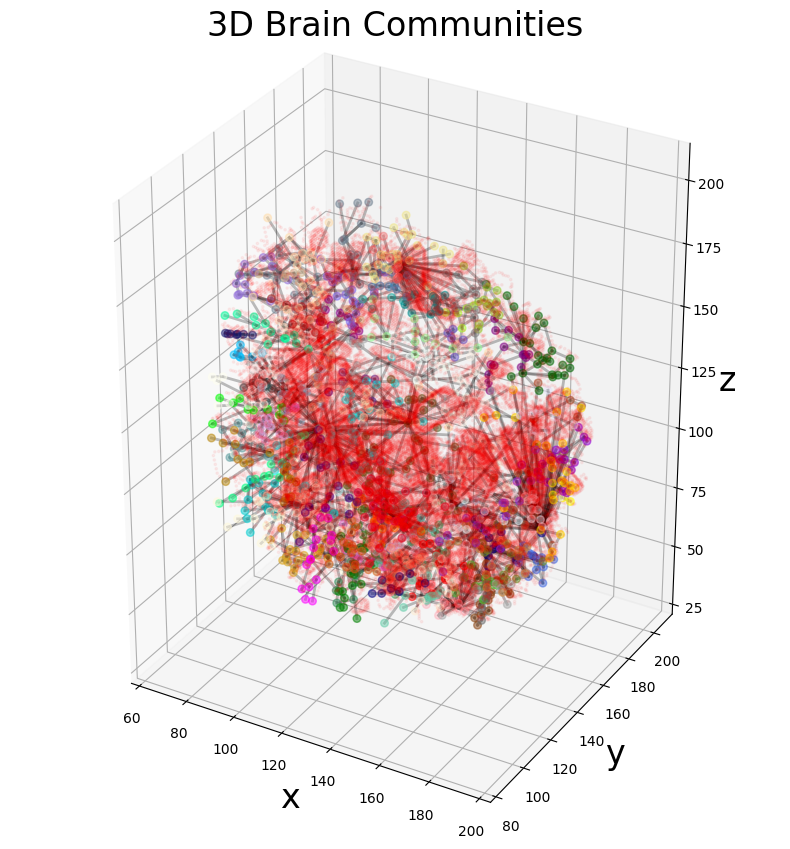

In [5]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Plot the skeleton points
sx, sy, sz = np.where(skeleton)
ax.scatter(sx, sy, sz, color='r', marker='o', s=3, alpha=0.05)

# Plot the nodes, using their x, y, z attributes for positions
colors = list(mcolors.CSS4_COLORS.keys())
np.random.shuffle(colors)

for com, color in zip(communities, colors):
    # Extract x, y, z coordinates for the nodes in each community
    com_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y'], graph.nodes[node]['z']) for node in com]
    ax.scatter(*zip(*com_coords), color=color, marker='o', s=30, alpha=0.5)

# Plot edges based on node coordinates
for ex, ey in graph.edges():
    x_coords = [graph.nodes[ex]['x'], graph.nodes[ey]['x']]
    y_coords = [graph.nodes[ex]['y'], graph.nodes[ey]['y']]
    z_coords = [graph.nodes[ex]['z'], graph.nodes[ey]['z']]
    ax.plot(x_coords, y_coords, z_coords, color='k', linewidth=2, alpha=0.25)

# Set plot labels and aspect
ax.set_box_aspect((np.ptp(sx), np.ptp(sy), np.ptp(sz)))
ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('y', fontsize=24)
ax.set_zlabel('z', fontsize=24)
_ = ax.set_title('3D Brain Communities', fontsize=24)

plt.show()

Now that I'm sure to have the same number of communities and parcellation areas, I can induce the parcellation generated by the communities and the communities generated by the parcellation.

Comparing the two should give inshighs on the possibility of building a consistent pipeline to generate parcellations from the structural MRI data alone.

In [6]:
from scipy.spatial import cKDTree

def assign_voxels_to_nearest_nodes(node_coords, binary_volume, communities,nodes_names):
    """
    Assign each voxel in a binary MRI volume to the community of the nearest node.

    Parameters:
    - node_coords: A list or array of 3D coordinates for each node in the network (shape: [num_nodes, 3]).
    - binary_volume: A 3D NumPy array representing the binary MRI volume (1 for voxels to include, 0 otherwise).
    - communities: A list of lists, where each sublist contains the indices of nodes belonging to a specific community.

    Returns:
    - voxel_node_map: A 3D array where each voxel contains the index of the nearest node.
    - voxel_community_map: A 3D array where each voxel contains the community index of the nearest node.
    """
    # Convert the list of lists `communities` to a dictionary mapping each node to its community index
    node_to_community = {}
    for community_index, nodes in enumerate(communities):
        for node in nodes:
            node_to_community[node] = community_index + 1
    # Get the shape of the volume
    volume_shape = binary_volume.shape

    # Get the coordinates of all active (1-valued) voxels in the binary volume
    voxel_indices = np.argwhere(binary_volume > 0)  # N x 3 array of voxel coordinates

    # Build a KD-tree for the node coordinates to enable efficient nearest-neighbor search
    tree = cKDTree(node_coords)

    # Find the index of the closest node for each voxel coordinate
    _, nearest_node_indices = tree.query(voxel_indices)

    # Create empty maps to store the nearest node and community indices for each voxel
    voxel_node_map = np.zeros(volume_shape, dtype=int)
    voxel_community_map = np.zeros(volume_shape, dtype=int)

    # Populate the voxel_node_map and voxel_community_map
    for voxel, node_index in zip(voxel_indices, nearest_node_indices):
        voxel_node_map[tuple(voxel)] = node_index
        node = nodes_names[node_index]
        voxel_community_map[tuple(voxel)] = node_to_community.get(node, -1)  # -1 if node not in any community

    return voxel_node_map, voxel_community_map

# Run the function
#voxel_node_map, voxel_community_map = assign_voxels_to_nearest_nodes(node_coords, binary_volume, community_map)

nodes_names = list(graph.nodes())
nodes_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y'], graph.nodes[node]['z']) for node in nodes_names]

node_map, community_map = assign_voxels_to_nearest_nodes(nodes_coords,  volume != 0, communities, nodes_names)

95


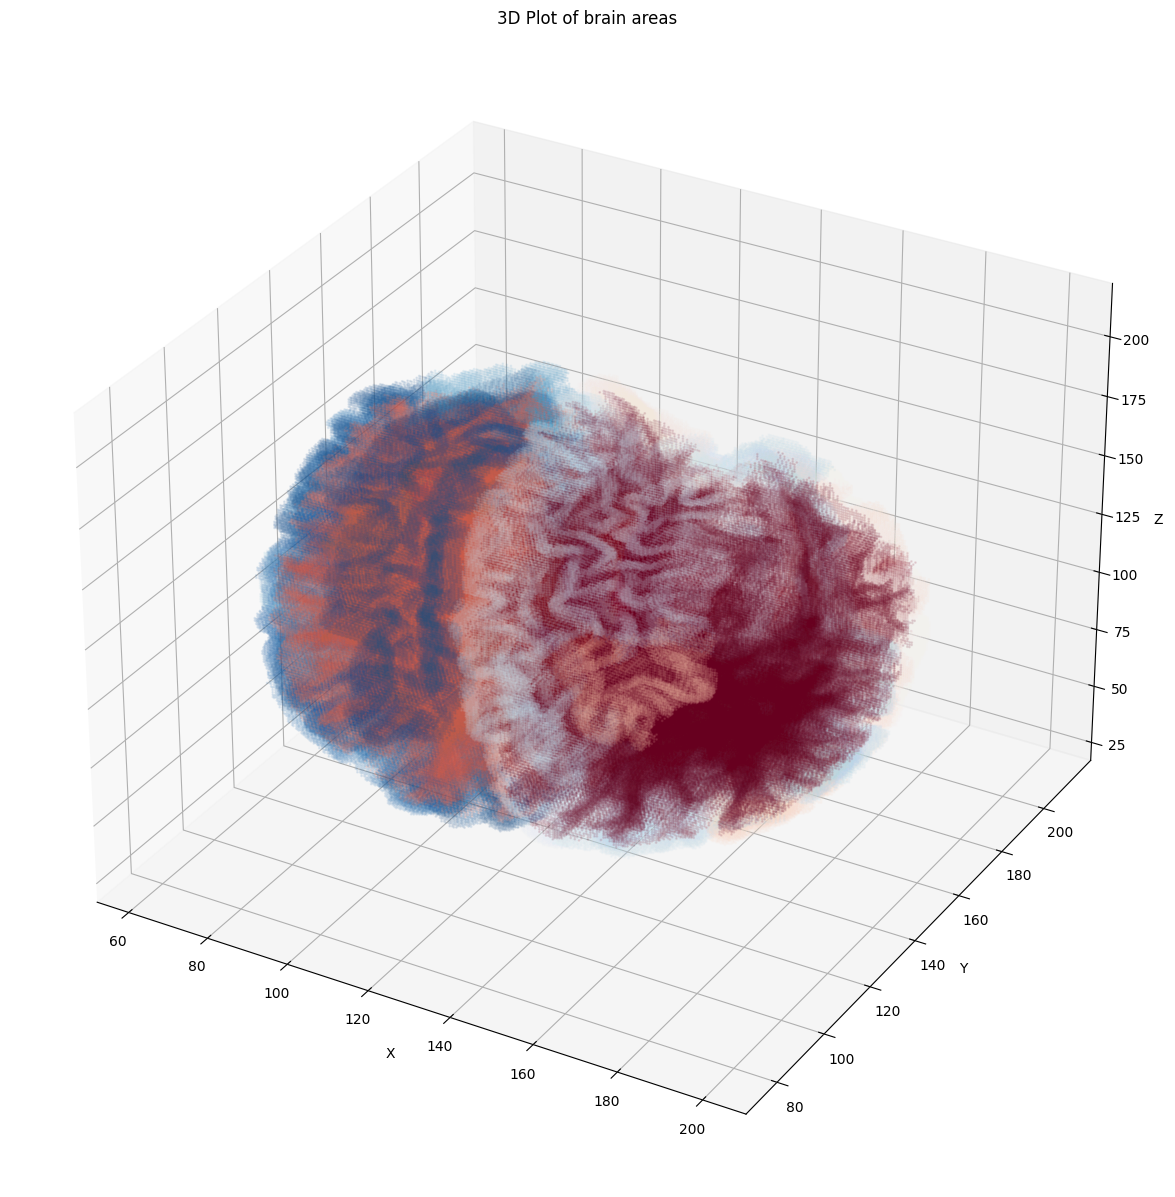

In [8]:

def plot_3d_matrix_general(matrix):
    """
    Plots points in 3D space for each unique entry in a 3D matrix,
    assigning a different color to each unique value, except for zero.

    Parameters:
    - matrix: 3D NumPy array with multiple unique values.
    """
    # Identify unique values in the matrix, excluding zero
    unique_values = np.unique(matrix)
    unique_values = unique_values[unique_values != 0]  # Exclude zero
    print(len(unique_values))
    
    # Set up a colormap
    colors = plt.cm.get_cmap("RdBu", len(unique_values))  # Use a colormap with enough colors
    
    # Create a 3D plot
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each unique value in the matrix with a different color
    for i, value in enumerate(unique_values):
        # Get the coordinates of all entries with the current value
        voxel_indices = np.argwhere(matrix == value)
        
        # Separate the coordinates into x, y, and z components
        x, y, z = voxel_indices[:, 0], voxel_indices[:, 1], voxel_indices[:, 2]
        
        # Plot the points with the color corresponding to the current value
        ax.scatter(x, y, z, c=[colors(i)],   alpha =.1, s= 1)#label=f'Value {value}',marker='o',

    # Set labels, title, and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Plot of brain areas')
    #ax.legend()
    plt.show()

plot_3d_matrix_general(volume)

96


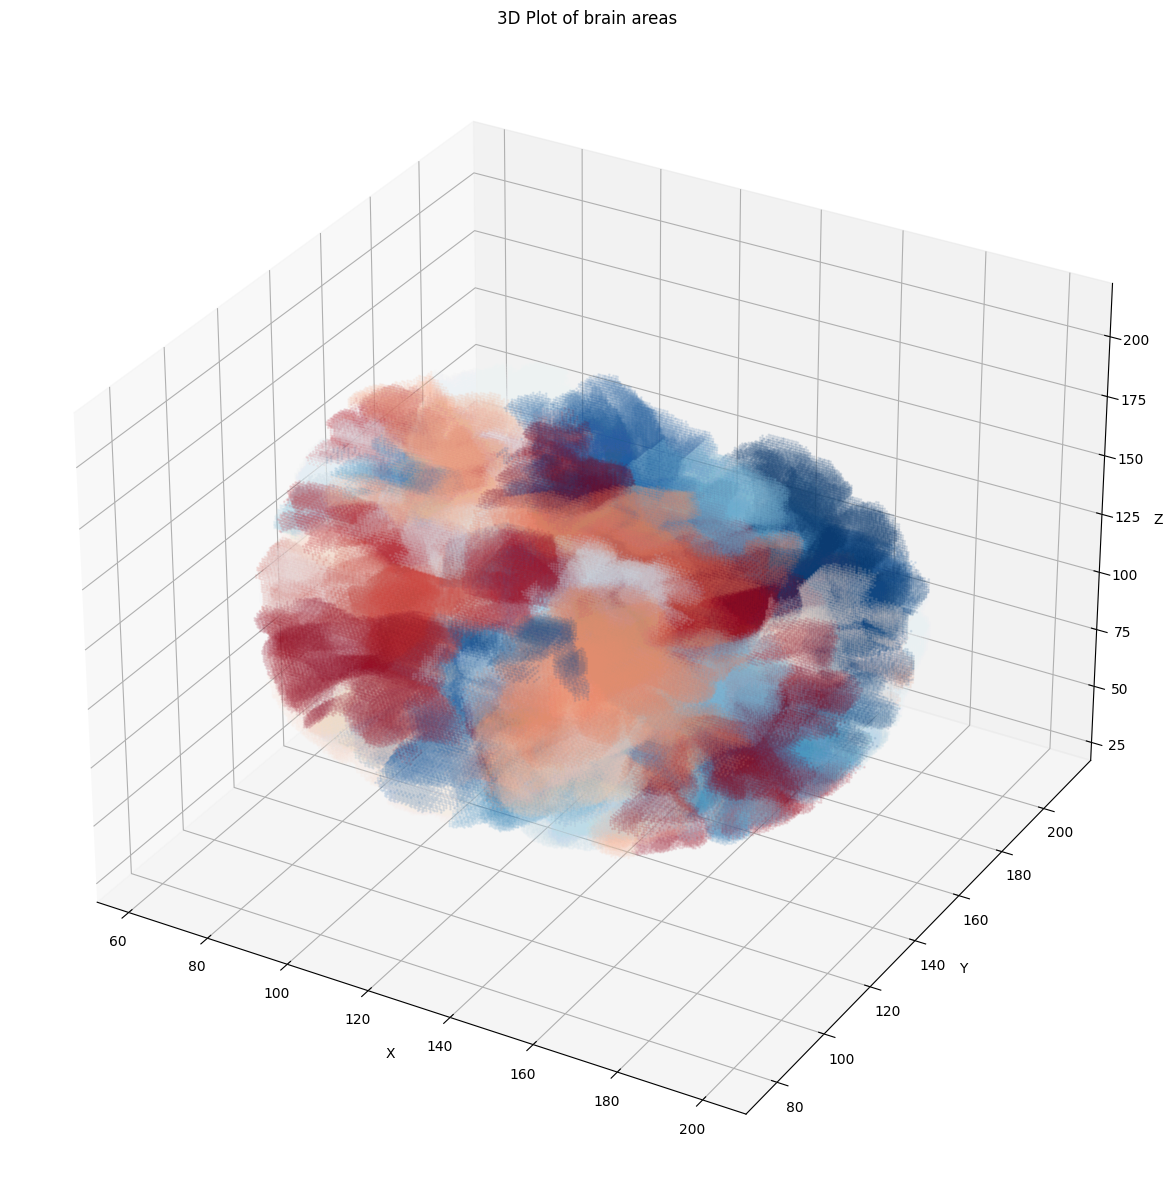

In [9]:
#Now the matrix maps the voxels to the nodes: I need to make a conversion from the nodes to the community

plot_3d_matrix_general(community_map)

In [82]:

def graph_to_dataframe(graph):
    """
    Convert a graph into a Pandas DataFrame, with each node as a row and node attributes as columns.

    Parameters:
    - graph: A NetworkX graph with nodes and attributes.

    Returns:
    - df: A Pandas DataFrame where each row represents a node, and columns represent node attributes.
    """
    # Extract node data from the graph
    node_data = []
    for node, attributes in graph.nodes(data=True):
        # Include the node ID in the attributes dictionary
        attributes['node'] = node
        node_data.append(attributes)

    # Convert the list of node dictionaries into a DataFrame
    df = pd.DataFrame(node_data)

    # Optional: Reorder to have 'node' as the first column
    if 'node' in df.columns:
        cols = ['node'] + [col for col in df.columns if col != 'node']
        df = df[cols]

    return df

graph_df = graph_to_dataframe(graph)
names_df = graph_df.pop('node')

In [83]:

def assign_parcellation_labels_to_nodes_direct(node_voxel_coords, mgz_file_path):
    """
    Assigns a parcellation label to each node based on its voxel coordinates in the brain.

    Parameters:
    - node_voxel_coords: A DataFrame with 'x', 'y', 'z' columns for node voxel coordinates.
    - mgz_file_path: Path to the MGZ file containing the parcellation map.

    Returns:
    - labeled_nodes: A DataFrame with an additional 'parcellation_label' column for each node.
    """
    # Verify that node_voxel_coords has the required columns
    if not all(col in node_voxel_coords.columns for col in ['x', 'y', 'z']):
        raise ValueError("node_voxel_coords must contain 'x', 'y', 'z' columns")

    # Load the parcellation volume from the MGZ file
    parcellation_img = nib.load(mgz_file_path)
    parcellation_data = parcellation_img.get_fdata()

    # Check the shape of the parcellation volume
    max_x, max_y, max_z = parcellation_data.shape
    #print("Parcellation data shape:", parcellation_data.shape)

    # Directly use voxel coordinates to get labels
    labels = []
    for x, y, z in node_voxel_coords[['x', 'y', 'z']].values:
        # Check if the voxel coordinates are within bounds
        if 0 <= x < max_x and 0 <= y < max_y and 0 <= z < max_z:
            label = parcellation_data[int(x), int(y), int(z)]  # Get the label at this voxel
        else:
            print(f"Voxel ({x}, {y}, {z}) is out of bounds")
            label = -1  # Assign -1 if the node is out of bounds
        labels.append(label)

    # Create a new DataFrame with the 'parcellation_label' column
    labeled_nodes = node_voxel_coords.copy()
    labeled_nodes['parcellation_label'] = labels

    return labeled_nodes

labeled_nodes = assign_parcellation_labels_to_nodes_direct(graph_df, image_path)
len(np.unique(labeled_nodes['parcellation_label'].to_numpy()))
#np.unique(labeled_nodes['parcellation_label'].to_numpy())

80

In [ ]:
#labeled_nodes#['parcellation_label']

for i, node in enumerate(graph.nodes()):
    #print(i, node)
    graph.nodes[node]['parcellation'] = labeled_nodes['parcellation_label'][i]




In [60]:


for community_idx, community in enumerate(communities):
    for node in community:
        # Add a 'community' attribute to each node
        graph.nodes[node]['community'] = community_idx






In [ ]:


def matrices_to_nonzero_lists(matrix1, matrix2):
    
    # Flatten the matrices and filter out zeros
    list1 = matrix1[matrix1 != 0].flatten().tolist()
    list2 = matrix2[matrix2 != 0].flatten().tolist()
    
    return list1, list2

# Example usage
matrix1 = np.array([[1, 0, 3], [0, 0, 6], [7, 8, 0]])
matrix2 = np.array([[0, 2, 0], [5, 0, 0], [0, 9, 10]])

# Run the function
list1, list2 = matrices_to_nonzero_lists(matrix1, matrix2)

print("List from matrix1 (non-zero values):", list1)
print("List from matrix2 (non-zero values):", list2)

List from matrix1 (non-zero values): [1, 3, 6, 7, 8]
List from matrix2 (non-zero values): [2, 5, 9, 10]


In [38]:
parcellation_labels, community_labels = matrices_to_nonzero_lists(volume,community_map)

if len(parcellation_labels) != len(community_labels):
    print('ERROR: mismatch between the number of entries')

In [47]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def compare_label_sets(labels_method1, labels_method2):
    """
    Compare two sets of labels using Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI).

    Parameters:
    - labels_method1: List or array of labels from the first method (e.g., node-based labels).
    - labels_method2: List or array of labels from the second method (e.g., voxel-based labels).

    Returns:
    - ari: Adjusted Rand Index score.
    - nmi: Normalized Mutual Information score.
    """
    # Ensure that labels are in the same format (e.g., both lists or arrays)
    labels_method1 = np.array(labels_method1)
    labels_method2 = np.array(labels_method2)

    # Compute Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(labels_method1, labels_method2)

    # Compute Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(labels_method1, labels_method2)

    return ari, nmi

# Example usage:
# Assume you have two lists or arrays of labels from two different methods
labels_method1 = [1, 2, 6, -3, 2, 1]  # Example label set 1 (node-based)
labels_method2 = [1, 100, 1, 3, 2, 1]  # Example label set 2 (voxel-based)

# Run the comparison function
ari, nmi = compare_label_sets(labels_method1, labels_method2)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.2857142857142857
Normalized Mutual Information (NMI): 0.7864379259835012


In [48]:

ari, nmi = compare_label_sets(parcellation_labels, community_labels)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.05208087220586589
Normalized Mutual Information (NMI): 0.4591860919713749


In [65]:
nodes_communities = [graph.nodes[node]['community'] for node in graph.nodes()]

nodes_parcellation = [graph.nodes[node]['parcellation'] for node in graph.nodes()]

ari, nmi = compare_label_sets(nodes_communities, nodes_parcellation)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.027373166810880454
Normalized Mutual Information (NMI): 0.46676984001081545


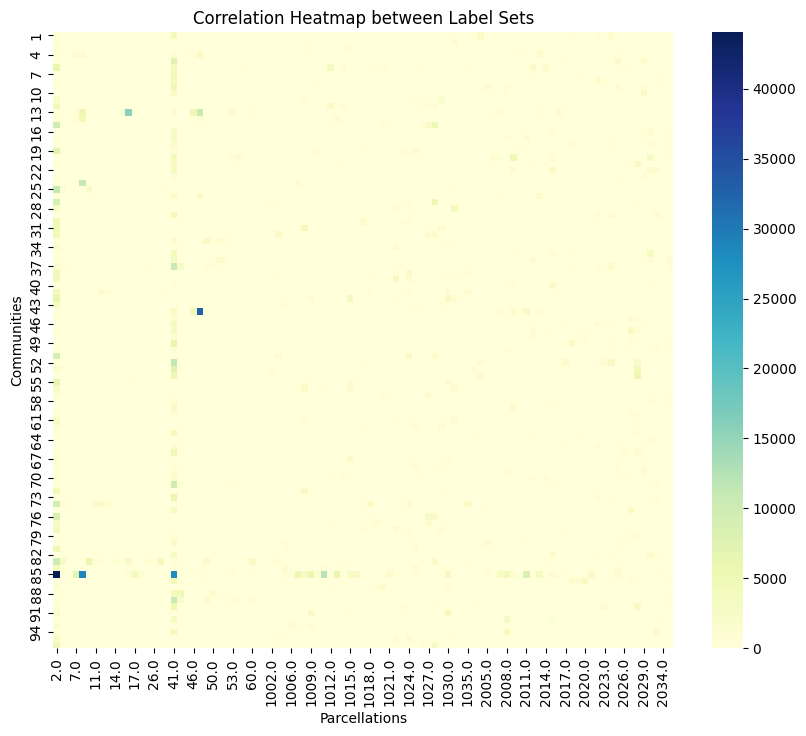

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def label_correlation_heatmap(labels_method1, labels_method2):
    # Ensure that both sets of labels are arrays
    labels_method1 = np.array(labels_method1)
    labels_method2 = np.array(labels_method2)

    # Create a contingency table (confusion matrix)
    contingency_table = pd.crosstab(labels_method1, labels_method2)
    #contingency_table = np.log(contingency_table.to_numpy())
    # Plot the heatmap using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(contingency_table, annot=False, fmt="d", cmap="YlGnBu", cbar=True)
    plt.xlabel("Parcellations")
    plt.ylabel("Communities")
    plt.title("Correlation Heatmap between Label Sets")
    plt.show()

# Example usage:
labels_method1 = [1, 2, 1, 3, 2, 1]  # Example label set 1 (node-based)
labels_method2 = [1, 2, 3, 1, 2, 3]  # Example label set 2 (voxel-based)

label_correlation_heatmap(community_labels, parcellation_labels )

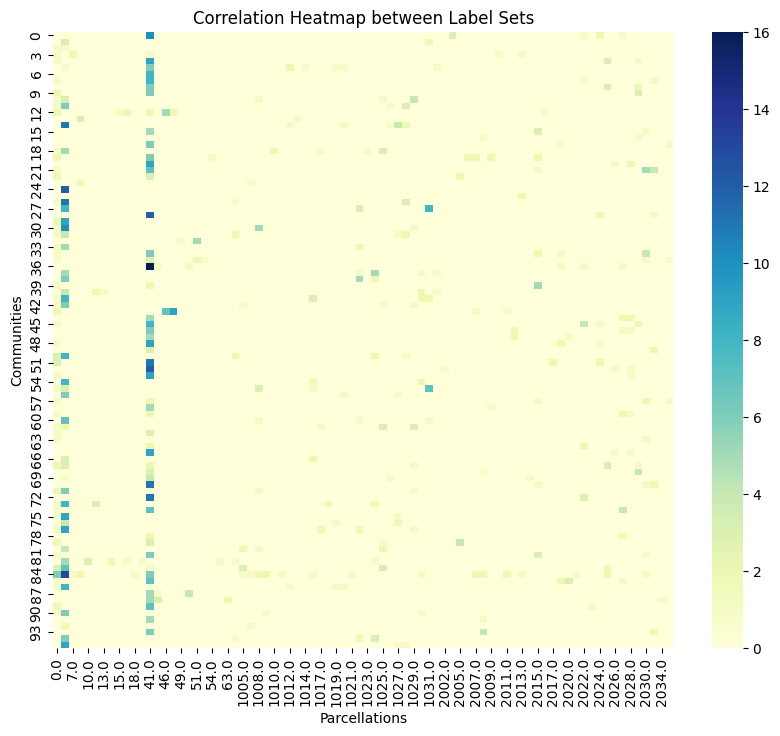

In [74]:

label_correlation_heatmap(nodes_communities, nodes_parcellation)